(inmunizacion_2)=
# Introdución

```{index} Inmunización estrategia
```

En este apartado se va a desarrollar una estrategia para inmunizar a una población frente a un determinado virus, el cual ya se ha comentado en el apartado dedicado al [modelo Discrete Quadratic Model](DQM). Aunque en este apartado se le da el enfoque de resolución de un problema de tipo [Constrained Quadratic Model](cqm).

La resolución del problema se puede <a href="https://github.com/dwave-examples/immunization-strategy/blob/main/demo.py" target="_blank"> localizar en internet en este enlace </a>, pero se ha considerado oportuno profundizar más en su desarrollo a fin de que el lector pueda conocer con mayor grado de detalle su solución.

La idea básica del problema es la siguiente: Existen muchas estrategias  para inmunizar poblaciones con el fin de prevenir la transmisión de un virus o una enfermedad infecciosa utilizando para ello un número mínimo de dosis. 

Una de esas estrategias, que será la utilizada en este apartado, es fragmentar una población en grupos separados a través de un "separador". Esta estrategia divide una población en dos grandes grupos de tamaño similar y un *tercer grupo que sirve como separador*. El separador se elige de modo que todas las conexiones entre los dos grupos más grandes pasen a través de él y debe mantenerse lo más pequeño posible. 

En este escenario, la eliminación del separador de la población desconecta los dos grandes grupos, evitando la transmisión de la infección entre los grupos. La inmunización del separador rompe el ciclo de transmisión, y así, seleccionar un separador que contenga la menor cantidad posible de individuos minimizará el número de dosis de inmunización requeridas. En este ejemplo, mostramos cómo se puede implementar este problema de optimización usando Ocean SDK y resolverlo usando el solucionador de modelo cuadrático restringido híbrido disponible en Leap.

En  en este problema a cada persona de la población se le va a asignar a un grupo de los tres que se van a tener encuenta:

* Grupo 0, es uno de los grandes grupo

* Grupo 1, es el otro gran grupo de población

* Grupo 2, es el grupo separador

Procedemos incialmente a cargar los módulos que necesitamos. 


In [35]:
import argparse
import sys
import matplotlib
import networkx as nx
from dimod import ConstrainedQuadraticModel, Binary, quicksum
from dwave.system import LeapHybridCQMSampler
import matplotlib.pyplot as plt

A continuación definimos una función que nos va a servir para elegir entre varios gráficos disponible, junto con las opciones de ese gráfico que deseamos utilizar.

Varios tipos diferentes de gráficos o redes están disponibles para esta demostración utilizando las opciones proporcionadas en la función que se desarrolla a continuación. Todos estos gráficos están construidos usando <a href="https://networkx.org/documentation/stable/index.html" target="_blank"> funciones del generador nerador de gráficos N </a>etwoalguno de rkX, y los depara elegir se indican a continuaciónr Los gráficos disponibles son los siguientes: a* quí .

karate: Gráfico del Club de Karate; un gráfico fijo en 34

* nodos.
internet: Red del Sistema Autónomo Internet; especifique el número de nodos entre 1000 

*  1666.
rand-reg: Un gráfico d-regular aleatorio; especifique el número de nodos y el valo

*  de d.
ER: Gráfico aleatorio de Erdos-Renyi; especificar el número de nodos y la probabilidad de

* borde.
SF: Gráfico sin escala de Barabasi-Albert; especifique el número de nodos y el número de bordes para agregar desde un nuevo nodo a cualquier nodo exi
* stente.
El gráfico predeterminado es el gráfico de Internet en 1000 nodos. El mayor número de nodos permitidos para cualquier gráfico especificado puede ser como máximo 1.666


In [2]:
def read_in_args(args):
    """ Read in user specified parameters."""

    # Set up user-specified optional arguments
    parser = argparse.ArgumentParser()
    parser.add_argument("-g", "--graph", default='internet', choices=['karate', 'internet', 'rand-reg', 'ER', 'SF'], 
                        help='Graph to partition (default: %(default)s)')
    parser.add_argument("-n", "--nodes", help="Set graph size for graph. (default: %(default)s)", default=1000, type=int)
    parser.add_argument("-d", "--degree", help="Set node degree for random regular graph. (default: %(default)s)", default=4, type=int)
    parser.add_argument("-p", "--prob", help="Set graph edge probability for ER graph. Must be between 0 and 1. (default: %(default)s)", default=0.25, type=float)
    parser.add_argument("-e", "--new-edges", help="Set number of edges from new node to existing node in SF graph. (default: %(default)s)", default=4, type=int)

    return parser.parse_args(args)

A continuación se muestra un ejemplo de cómo poder hacer las elecciones que nos ofrece la función anterior.

In [29]:
#args = read_in_args(sys.argv[1:])
args = read_in_args(['--graph','karate','--nodes','500'])

In [30]:
# Veamos los valores que hemos elegido
args

Namespace(degree=4, graph='karate', new_edges=4, nodes=500, prob=0.25)

Una vez elegidas las opciones que nos ofrece la función anterior, su resultado lo utilizamos para cosntruir el gráfico, el cual será dibujado posteriormente.

In [36]:
def build_graph(args):
    
    """Construimos el gráfico con los parámetros definidos anteriormente"""

    max_vars = int(5000/3)
    
    # Build graph using networkx
    if args.graph == 'karate':
        print("\nReading in karate graph...")
        G = nx.karate_club_graph()
    elif args.graph == 'internet':
        if args.nodes < 1000 or args.nodes > max_vars:
            args.nodes = 1000
            print("\nSize for internet graph must be between 1000 and " + str(max_vars) + ". Setting size to 1000.\n")
        print("\nReading in internet graph of size", args.nodes, "...")
        G = nx.random_internet_as_graph(args.nodes)
    elif args.graph == 'rand-reg':
        if args.nodes < 1 or args.nodes > max_vars:
            print("\nSize for random regular graph must be between 1 and " + str(max_vars) + ". Setting size to 1000.\n")
        if args.degree < 0 or args.degree >= args.nodes:
            print("\nDegree must be between 0 and n-1. Setting size to min(4, n-1).\n")
            args.degree = min(4, args.nodes-1)
        if args.degree*args.nodes % 2 == 1:
            print("\nRequirement: n*d must be even.\n")
            if args.degree > 0:
                args.degree -= 1
                print("\nSetting degree to", args.degree, "\n")
            elif args.nodes-1 > args.degree:
                args.nodes -= 1
                print("\nSetting nodes to", args.nodes, "\n")
            else:
                print("\nSetting nodes to 1000 and degree to 4.\n")
                args.nodes = 1000
                args.degree = 4
        print("\nGenerating random regular graph...")
        G = nx.random_regular_graph(args.degree, args.nodes)
    elif args.graph == 'ER':
        if args.nodes < 1 or args.nodes > max_vars:
            print("\nSize for ER graph must be between 1 and " + str(max_vars) + ". Setting size to 1000.\n")
            args.nodes = 1000
        if args.prob < 0 or args.prob > 1:
            print("\nProbability must be between 0 and 1. Setting prob to 0.25.\n")
            args.prob = 0.25
        print("\nGenerating Erdos-Renyi graph...")
        G = nx.erdos_renyi_graph(args.nodes, args.prob)
    elif args.graph == 'SF':
        if args.nodes < 1 or args.nodes > max_vars:
            print("\nSize for SF graph must be between 1 and " + str(max_vars) + ". Setting size to 1000.\n")
            args.nodes = 1000
        if args.new_edges < 0 or args.new_edges > args.nodes:
            print("\nNumber of edges must be between 1 and n. Setting to 5.\n")
            args.new_edges = 5
        print("\nGenerating Barabasi-Albert scale-free graph...")
        G = nx.barabasi_albert_graph(args.nodes, args.new_edges)
    else:
        print("\nReading in karate graph...")
        G = nx.karate_club_graph()

    return G

Procedemos a construir el gráficos de la siguient manera

In [32]:
G = build_graph(args)


Reading in karate graph...


In [37]:
# Visualize the input graph
def visualize_input_graph(G, guardar='N'):
    """ Visualizamos el gráfico que va a ser particionado, el parámetro guardar se utiliza por si queremos almacenar
        en un fichero denominado input_graph.png el resultado
    """

    pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G, pos, node_size=20, node_color='r', edgecolors='k')
    nx.draw_networkx_edges(G, pos, edgelist=G.edges(), style='solid', edge_color='#808080')
    plt.draw()
    if guardar=='N':
        plt.show()
    else:
        plt.savefig('input_graph.png')
    plt.close()

Visualizamos el resultado de la forma predefinida, es decir mostrando el gráfico por pantalla

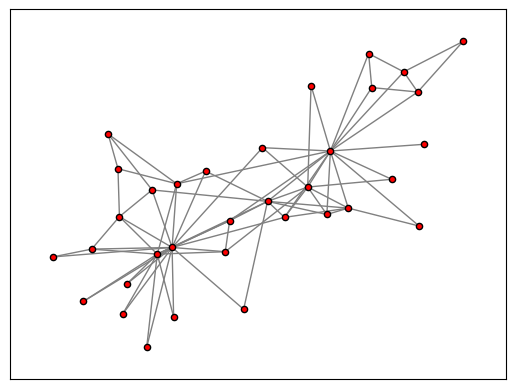

In [38]:
visualize_input_graph(G)

Ahora ya viene la parte más interesante del problema, construir las instrucciones Python para enviar a los ordenadores de D-Wave para que nos resuelvan el problema, y en este caso lo resolveremos <a href="https://docs.ocean.dwavesys.com/en/stable/concepts/cqm.html" target="_blank"> utilizando la clase ConstrainedQuadraticModel() </a>.

Los pasos que damos son los siguientes:

1.- Definimos con la variable *num_groups* el número de grupos, que serán 3 como ya se ha explicado en apartado anterior.

![grupos de inmunización](../img/GruposInmunizacion.PNG)

2.- Se procede a construir una instancia de la clase CQM

3.- Creamos las variables binarias $x_{i,j}$, donde el índice i hace referencia al nodo o la personas y el índice j a la clase de pertenencia, que puede ser 0,1 ó 2. Observar que la construcción de estas variables es mediante dos list comprehesion ( una añadida a la otra), con lo que se obtiene una lista de listas, de tal manera que la lista más interna tiene tres elementos, y la más externa el número de nodos de la red y sus elementos son las listas internas.

4.- Se construye la función objetivo, de tal manera que lo que se quiere minimizar es el número de personas (o nodos) que hay en el grupo 2. Por lo tanto la función objetivo sería la siguiente:

$$\sum_{i=0}^{N}x_{i,2}$$

Para construir esta función objetivo se utiliza <a href="https://docs.ocean.dwavesys.com/en/stable/docs_dimod/reference/generated/dimod.binary.quicksum.html" target="_blank"> la función quicksum </a> muy utilizada en este tipo de problemas.

5.- Ahora hay que tener en cuenta que cada nodo o persona debe pertener a un sólo grupo, lo que se traduce en que para cada i la suma en j de $x_{i,j}$ debe ser 1. Es decir:

$$\sum_{j=0}^{2}x_{i,j}=1\ \ \forall i=1,2,...,N$$

```{index} cqm.add_discrete(), add_discrete()
```
Via código esto se consigue utilizando la propiedad *add_discrete(). **NOTA IMPORTANTE**. Esta consición es muy importante y hay que tenerla en cuenta en todos los problemas de variables discretas que se resuelvan con el modelo CQM().*
6.- Ahora debemos de tener en cuenta que una de las restricciones de nuestro problema es que el número de personas en el grupo 0 será igual al número de personas del grupo 1. O lo que es lo mismo:

$$\sum_{i=1}^{N}x_{i,0}=\sum_{i=1}^{N}x_{i,1}$$

**NOTA**. Observar que lo escrito en el código es la forma que admite Ocean SDK, pues a la derecha del signo igual no admite ninguna expresión, solo un valor determinado.

7.- Ahora nos falta añadir la restricción de que no haya arcos entre el grupo 0 y el grupo 1. Observar que cunado hay un arco entre elementos de estos dos grupos se debe cumplir que vars[a][0]*vars[b][1]=1 o que vars[a][1]*vars[b][0]= 1, para lo cual los dos elementos del producto deben valer 1 (tener en cuenta que nuestras variables sólo pueden valer 0 ó 1)



In [39]:
def build_cqm(G):
    """ Build the CQM for the problem instance."""
    
    # Definimos el número total de grupos : 1
    # Dos grupos más numerosos (valores 0, 1) y un grupo que actúa como separador (case 2)
    num_groups = 3

    # Initialize the CQM object
    print("\n Construyendo CQM...")
    # Creamos una instancia del modelo CQM : 2
    cqm = ConstrainedQuadraticModel()

    # Build the CQM starting by creating variables
    # Creamos las variables binarias (0 ó 1) Xij (i=nodo o persona ; j=grupo de pertenencia: 0,1 ó 2) : 3
    vars = [[Binary(f'x_{name}_{i}') for i in range(num_groups)] for name in G.nodes()]

    # Función objetivo para el modelo  CQM :4
    cqm.set_objective(quicksum(vars[i][2] for i in range(len(vars))))

    # Añadimos la restricción para que las variables sean discretas :5
    for v in range(len(vars)):
        cqm.add_discrete([f'x_{v}_{i}' for i in range(num_groups)])

   
    # Añadimos la restricción de que el número de  elementos del grupo 0 es igual a los del grupo 1 : 6
    g1 = [vars[i][0] for i in range(len(vars))]
    g2 = [vars[i][1] for i in range(len(vars))]
    cqm.add_constraint(quicksum(g1) - quicksum(g2) == 0)

    # añadimos la restricción de que entre los grupos 0 y 1 no hay arcos (e(G0,G1)=0):7
    edge_sum = []
    for a, b in G.edges():
        if a != b:
            edge_sum.append(vars[a][0]*vars[b][1]+vars[a][1]*vars[b][0])
    cqm.add_constraint(quicksum(edge_sum) == 0, label='cross edges')

    print("\n  ... CQM construido")
    return cqm

Con todas estas premisas, ahora ya estamos en disposición de crear nuestro modelo CQM

In [40]:
cqm = build_cqm(G)


 Construyendo CQM...

  ... CQM construido


Ahora ya vamos a definir la función que ejecute nuestro modelo con un sampler.

In [24]:
def run_cqm_and_collect_solutions(cqm, sampler):
    """ Send the CQM to the sampler and return the best sample found."""

    # Initialize the solver
    print("\nSending to the solver...")
    
    # Solve the CQM problem using the solver
    sampleset = sampler.sample_cqm(cqm, label='Example - Immunization Strategy')

    # Observar que filtramos las soluciones para obtener las soluciones factibles 
    feasible_sampleset = sampleset.filter(lambda d: d.is_feasible)
    if len(feasible_sampleset) == 0:
        print("\nNo feasible solution found. Returning best infeasible solution.")
        # devolvemos si existe la mejor solución factible
        return sampleset.first.sample

    return feasible_sampleset.first.sample

A continuación definimos el sampler que vamos a utilizar  para pasarlo como parámetro de la función *run_cqm_and_collect_solutions()*:

In [ ]:
# Definimos el sampler
sampler = LeapHybridCQMSampler()
# Ejecutamos en el sampler nuestro modelo
sample = run_cqm_and_collect_solutions(cqm, sampler)

Con la solución anterior ya podemos formas los tres grupos que buscamos

In [25]:
def process_sample(G, sample):
    """ Interpret the CQM solution in terms of the partitioning problem."""

    # Display results to user
    group_1 = []
    group_2 = []
    sep_group = []
    results = [[],[],[]]
    for key, val in sample.items():
        if val == 1:
            v = key.split("_")
            results[int(v[-1])].append(int(v[1]))

    group_1 = results[0]
    group_2 = results[1]
    sep_group = results[2]

    # Display best result
    print("\nPartition Found:")
    print("\tGroup 1: \tSize", len(group_1))
    print("\tGroup 2: \tSize", len(group_2))
    print("\tSeparator: \tSize", len(sep_group))

    print("\nSeparator Fraction: \t", len(sep_group)/len(G.nodes()))

    # Determines if there are any edges directly between the large groups
    illegal_edges = [(u, v) for u, v in G.edges if (sample[f'x_{u}_{0}']*sample[f'x_{v}_{1}'] == 1 or sample[f'x_{u}_{1}']*sample[f'x_{v}_{0}'] == 1)]

    print("\nNumber of illegal edges:\t", len(illegal_edges))

    return group_1, group_2, sep_group, illegal_edges

Ejecutamos la función anterior

In [ ]:
group_1, group_2, sep_group, illegal_edges = process_sample(G, sample)

Ya podemos ver el resultado obtenido

In [26]:
def visualize_results(G, group_1, group_2, sep_group, illegal_edges, guardar='N' ):
    """ Visualize the partition."""

    print("\nVisualizing output...")

    G1 = G.subgraph(group_1)
    G2 = G.subgraph(group_2)
    SG = G.subgraph(sep_group)

    pos_1 = nx.random_layout(G1, center=(-5,0))
    pos_2 = nx.random_layout(G2, center=(5,0))
    pos_sep = nx.random_layout(SG, center=(0,0))
    pos = {**pos_1, **pos_2, **pos_sep}

    nx.draw_networkx_nodes(G, pos_1, node_size=10, nodelist=group_1, node_color='#17bebb', edgecolors='k')
    nx.draw_networkx_nodes(G, pos_2, node_size=10, nodelist=group_2, node_color='#2a7de1', edgecolors='k')
    nx.draw_networkx_nodes(G, pos_sep, node_size=10, nodelist=sep_group, node_color='#f37820', edgecolors='k')

    nx.draw_networkx_edges(G, pos, edgelist=G.edges(), style='solid', edge_color='#808080')
    nx.draw_networkx_edges(G, pos, edgelist=illegal_edges, style='solid')

    plt.draw()
    if guardar=='N':
        plt.show()
    else:
        output_name = 'separator.png'
        plt.savefig(output_name)

    print("\tOutput stored in", output_name)

Ejecutamos la función anterior para ver el resultado

In [ ]:
visualize_results(G, group_1, group_2, sep_group, illegal_edges)